In [2]:
import json
from pymongo import MongoClient

In [3]:
URI = "mongodb://localhost:27017/"

In [4]:
def collection(uri):
    client = MongoClient(uri)
    database = client["rhobs"]
    collection = database["people"]
    return collection
def load(uri="localhost", datapath="data.json"):
    coll = collection(uri=uri)
    with open(datapath, "r") as fp:
        data = json.load(fp)
        for person in data:
            coll.insert_one(person)

In [5]:
client = MongoClient()
# Eviter de reload la collection
if 'rhobs' not in client.list_database_names():
    load()


In [6]:
def count_gender(gender):
    col = collection(URI)
    query = {"sex":gender}
    return col.count_documents(query)

In [7]:
n_hommes,n_femmes = count_gender("M"),count_gender("F")
print(f"Nombre d'hommes {n_hommes}\nNombre de femmes : {n_femmes}")

Nombre d'hommes 24958
Nombre de femmes : 25042


In [8]:
def count_companies(n):
    col = collection(URI)
    pipeline = [
        {
            "$group": 
            { 
                "_id": "$company", 
                "count": {"$sum": 1}
            }
        },
        {
            "$match":
            {
                "count": {"$gt":n}
            }
        }
    ]

    result = col.aggregate(pipeline)

    for record in result:
        print(record)
count_companies(80)

{'_id': 'Gay', 'count': 84}
{'_id': 'Bernard', 'count': 81}
{'_id': 'Evrard', 'count': 83}
{'_id': 'Pottier', 'count': 81}
{'_id': 'Monnier', 'count': 81}
{'_id': 'Normand', 'count': 82}
{'_id': 'Bonnet', 'count': 82}
{'_id': 'Leclercq', 'count': 81}


In [9]:
import pandas as pd
import datetime
job='chargé de recherche en acoustique musicale'
def grab_data(job=job,sex='M'):
    col = collection(URI)

    records = col.find(
            {'job' : job,
            'sex' : sex
    },{"birthdate"})

    male_data = pd.DataFrame(list(records))
    male_data = pd.DataFrame(male_data.iloc[:,1])
    age_liste = []
    for birthdate in male_data['birthdate']:
        age_liste.append((datetime.date.today().year-datetime.datetime.strptime(birthdate,'%Y-%m-%d').date().year))
    
    return age_liste



In [10]:

tranche_d_age = 4 # tranches de quatres annnees
age_maximum = 100 # maximum d'ages( 100 ans )

def range_of_ages(tranche_d_age=tranche_d_age,age_maximum=age_maximum):
    """Retourne une liste des tranches d'ages """
    result = []
    number_of_tranches = (age_maximum-tranche_d_age)//(tranche_d_age+1)+1 #
    # nombre total de tranches
    k=0 # debuter la premiere tranche d'age
    for i in range(0,number_of_tranches):

        j=k+tranche_d_age # fin d'une tranche d'age
        result.append({"age":str(k)+'-'+str(j),"count":0})
        k=j+1
    result[number_of_tranches-1]={"age":'100+',"count":0}
    return result


In [15]:

def count_by_age(age_data):
    list_tranche_ages = range_of_ages()
    for age in age_data:
        if age <age_maximum:
            index = len(list_tranche_ages)*age//age_maximum
        else:
            index = len(list_tranche_ages)-1
        list_tranche_ages[index]["count"]+=1

    return list_tranche_ages



In [16]:
import matplotlib.pyplot as plt
def pyramide_des_ages_par_metier(job=job):
    # donnees retires de la collection
    male_data = grab_data(job,'M')
    female_data = grab_data(job,'F')
    #
    pyramid_des_ages = {
    'male_count_by_age':list(map(lambda element:element['count'],count_by_age(male_data))),
    'female_count_by_age':list(map(lambda element:element['count'],count_by_age(female_data))),
    'ages':list(map(lambda element:element['age'],range_of_ages()))
}
    # donnes sur le metier
    pyramid_des_ages_df = pd.DataFrame({"males":pyramid_des_ages["male_count_by_age"],"females":pyramid_des_ages['female_count_by_age'],"ages":pyramid_des_ages["ages"]})

    pyramid_des_ages_df ["females_left_side"] = 0
    pyramid_des_ages_df ["females_width"] = pyramid_des_ages_df["females"]

    pyramid_des_ages_df ["males_left_side"] = -pyramid_des_ages_df["males"]
    pyramid_des_ages_df ["males_width"] = pyramid_des_ages_df["males"]

    # Construction de figures

    fig = plt.figure(figsize=(15,14))
    plt.barh(y=pyramid_des_ages_df["ages"],width=pyramid_des_ages_df["females_width"],label="Femmes",
             left=pyramid_des_ages_df["females_left_side"])
    plt.barh(y=pyramid_des_ages_df["ages"],width=pyramid_des_ages_df["males_width"],left=pyramid_des_ages_df["males_left_side"],label="hommes")
    plt.text(-12,20,"Hommes",fontsize=20)
    plt.text(8,20,"Femmes",fontsize=20)
    plt.xlim(-15,15)
    plt.xlabel("nombres",fontweight="bold",fontsize=20)
    plt.ylabel("tranche d'ages",fontweight="bold",fontsize=20)
    plt.title(f"Pyramide des ages du metier {job}".format(job=job),fontweight="bold",fontsize=30)
    plt.legend(loc='best')

    for idx in range(len(pyramid_des_ages_df)):
        plt.text(x=pyramid_des_ages_df["males_left_side"][idx]-0.1,y=idx,ha='right',va='center',s="{}".format(pyramid_des_ages_df["males"][idx]),fontsize=20,fontweight="bold")
        plt.text(x=pyramid_des_ages_df["females_width"][idx]+1,y=idx,ha='right',va='center',s="{}".format(pyramid_des_ages_df["females"][idx]),fontsize=20,fontweight="bold")
    plt.show()

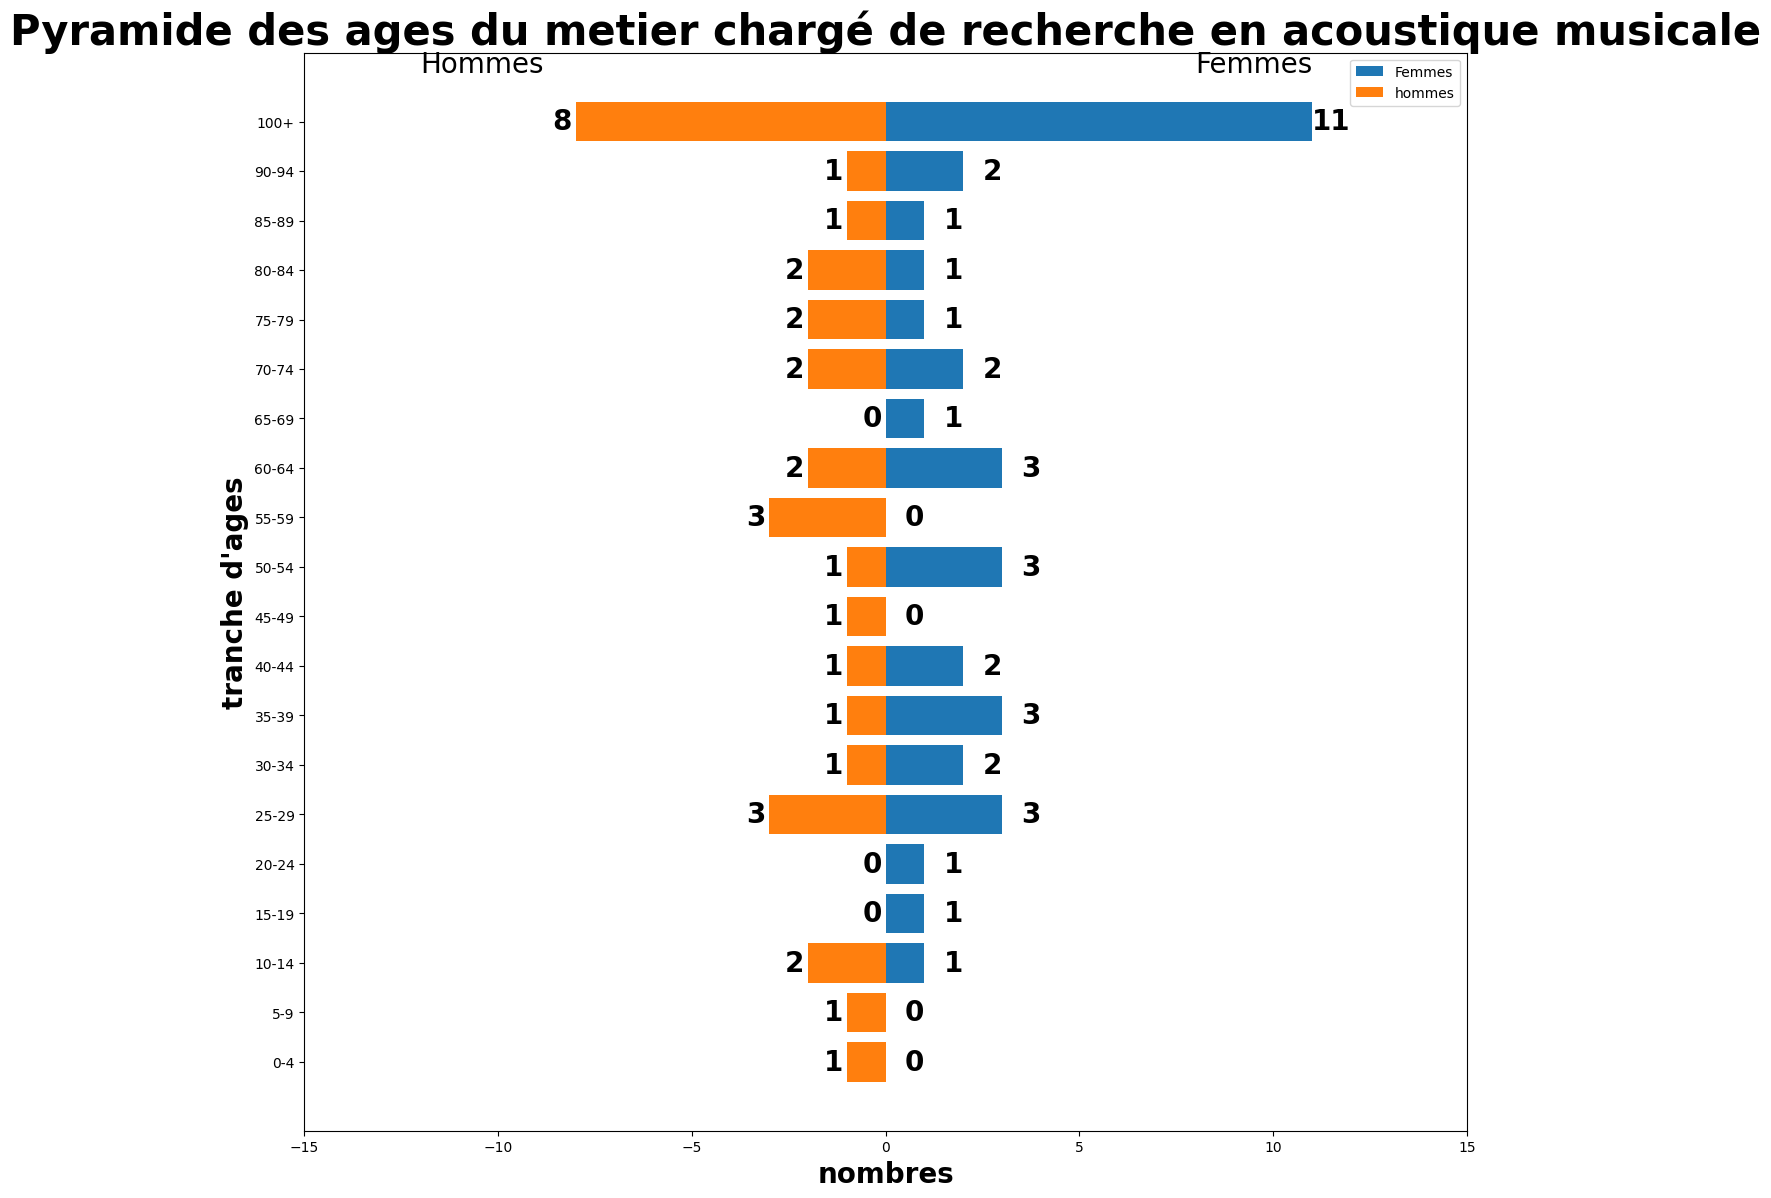

In [18]:
# Afficher le piramide
pyramide_des_ages_par_metier(job=job)

24